In [2]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

def seed_everything(seed:int=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

warnings.filterwarnings('ignore')
seed_everything()

In [3]:
df = pd.read_csv('./dataset/ff.csv')
target = 'BE5_1'
idx = df[target].dropna().index
df = df.loc[idx]
df.head(3)

,year,HE_FEV1FVC,age,Total_slp_wk,sex,occp,EC1_1,cfam,marri_1,BH9_11,...,EC_pedu_1,EC_pedu_2,BS5_1,BD7_4,eq_5d,sm_present,mh_stress,cage,BE3_31,BE5_1
0,2007.0,0.699366,74.0,8.0,1.0,0.0,0.0,2.0,1.0,0.0,...,9.0,9.0,비흡연자,없었음,0.720,1,1.0,7,7.0,0.0
1,2007.0,0.699220,69.0,NaN,1.0,1.0,1.0,2.0,1.0,1.0,...,초졸이하,초졸이하,비흡연자,1년동안있었음,1.000,1,0.0,6,7.0,0.0
2,2007.0,0.698630,80.0,6.0,0.0,0.0,0.0,1.0,1.0,1.0,...,9.0,9.0,비흡연자,없었음,0.723,0,0.0,7,0.0,0.0


In [4]:
df.drop(['year', 'LQ1_mn'], axis=1, inplace=True)
df = df[df['Total_slp_wk'] <= 24]

In [5]:
def make_targets(targets):
    return 1 if targets >=5 else 0

df[target] = df.apply(
    lambda row: make_targets(row[target]), axis=1
)

In [6]:
df[target].value_counts()

BE5_1
0    3305
1     415
Name: count, dtype: int64

In [7]:
# 1차년도
NUMERIC = ['year', 'HE_FEV1FVC', 'age', 'Total_slp_wk']
CATEGORICAL = ['sex', 'occp', 'EC1_1', 'cfam', 'marri_1', 'BH9_11', 'HE_DM', 'DC6_dg', 'DF2_dg', 'HE_HPdg', 'BP5']
ONE_HOT = ['BS3_1', 'edu', 'BP1', 'D_1_1', 'LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL', 'BO1_1', 'BO2_1']
# 2차년도
NUMERIC2 = ['DI1_ag', 'DE1_ag', 'LQ1_mn', 'BS6_2_1', 'BS6_3']
CATEGORICAL2 = ['DI1_pt', 'DE1_pt', 'DE1_3', 'BH1', 'BH2_61', 'LQ4_00', 'LQ4_05', 'LQ1_sb', 'MO1_wk', 'HE_cough1', 'HE_sput1', 'BD1', 'BD7_5', 'BP6_10', 'BP6_31']
ONE_HOT2 = ['DI1_2', 'EC_pedu_1', 'EC_pedu_2', 'BS5_1', 'BD7_4']
# 생성변수
NUMERIC3 = ['eq_5d']
CATEGORICAL3 = ['sm_present', 'mh_stress']
ONE_HOT3 = ['cage']
# Targets
TARGETS = ['BE3_31', 'BE5_1']

f_NUMERIC = (NUMERIC + NUMERIC2 + NUMERIC3).copy()
for idx in ['DI1_ag', 'DE1_ag']:
    f_NUMERIC.remove(idx)

f_CATEGORICAL = CATEGORICAL + CATEGORICAL2 + CATEGORICAL3.copy()
for idx in ['DC6_dg', 'DF2_dg', 'DI1_pt', 'DE1_pt', 'DE1_3', 'BP6_31']:
    f_CATEGORICAL.remove(idx)

f_ONE_HOT = ONE_HOT + ONE_HOT2 + ONE_HOT3.copy()
f_ONE_HOT.remove('DI1_2')

In [8]:
df.isna().sum().sort_values(ascending=False)

HE_cough1       900
HE_sput1        899
EC_pedu_1       736
EC_pedu_2       613
HE_DM           581
BD7_4           556
BD7_5           490
BH9_11          390
BP6_10          389
BP5             386
BH1             344
BS5_1           162
occp             12
EC1_1             6
edu               6
marri_1           5
LQ4_00            4
BS6_3             3
BH2_61            3
BS6_2_1           3
BE3_31            3
cfam              3
LQ_4EQL           3
LQ_5EQL           2
BO1_1             2
mh_stress         2
BP1               2
LQ_3EQL           2
D_1_1             2
LQ_1EQL           2
LQ_2EQL           2
MO1_wk            1
BS3_1             1
BO2_1             1
sm_present        0
cage              0
eq_5d             0
HE_FEV1FVC        0
BD1               0
LQ1_sb            0
LQ4_05            0
age               0
HE_HPdg           0
sex               0
Total_slp_wk      0
BE5_1             0
dtype: int64

In [9]:
df.drop([
    'HE_cough1', 'HE_sput1', 'EC_pedu_1', 'EC_pedu_2', 'HE_DM', 'BD7_4', 'BD7_5', 'BH9_11', 'BP6_10',
    'BP5', 'BH1', 'BS5_1'
], axis=1, inplace=True)

In [10]:
df.isna().sum().sort_values(ascending=False)

occp            12
EC1_1            6
edu              6
marri_1          5
LQ4_00           4
BE3_31           3
cfam             3
BH2_61           3
BS6_3            3
BS6_2_1          3
LQ_4EQL          3
LQ_5EQL          2
LQ_3EQL          2
BO1_1            2
LQ_1EQL          2
LQ_2EQL          2
D_1_1            2
BP1              2
mh_stress        2
MO1_wk           1
BO2_1            1
BS3_1            1
sm_present       0
cage             0
eq_5d            0
BD1              0
HE_FEV1FVC       0
LQ1_sb           0
LQ4_05           0
age              0
HE_HPdg          0
sex              0
Total_slp_wk     0
BE5_1            0
dtype: int64

In [11]:
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [12]:
X = df.drop('BE5_1', axis=1)
y = df['BE5_1']

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)
val_X, test_X, val_y, test_y = train_test_split(val_X, val_y, test_size=.2, stratify=val_y, random_state=42)
print(f'train size: {len(train_X)}')
print(f'validate size: {len(val_X)}')
print(f'test size: {len(test_X)}')

train size: 2976
validate size: 595
test size: 149


In [64]:
ada = ADASYN(random_state=42)
ada_X, ada_y = ada.fit_resample(train_X, train_y)

In [15]:
for val in f_NUMERIC:
    if val not in list(train_X.columns):
        f_NUMERIC.remove(val)
        print(val)

for val in f_CATEGORICAL:
    if val not in list(train_X.columns):
        f_CATEGORICAL.remove(val)
        print(val)

for val in f_ONE_HOT:
    if val not in list(train_X.columns):
        f_ONE_HOT.remove(val)
        print(val)

BD7_4


In [16]:
standard = StandardScaler()
onehot = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', standard, f_NUMERIC),
        ('onehot', onehot, f_ONE_HOT)
    ]
)
train_X = preprocessor.fit_transform(train_X)
# ada_X = preprocessor.fit_transform(ada_X)
val_X = preprocessor.transform(val_X)
test_X = preprocessor.transform(test_X)

In [191]:
# smote = SMOTE(random_state=42)
# adasyn = ADASYN(random_state=42)

# X_sm, y_sm = smote.fit_resample(train_X, train_y)
# X_ada, y_ada = adasyn.fit_resample(train_X, train_y)

In [25]:
# model = keras.Sequential(
#     [
#         keras.Input(shape=train_X.shape[1:]),
#         keras.layers.Dense(256, activation="relu"),
#         keras.layers.Dense(256, activation="relu"),
#         keras.layers.Dropout(0.3),
#         keras.layers.Dense(256, activation="relu"),
#         keras.layers.Dropout(0.3),
#         keras.layers.Dense(1, activation="sigmoid"),
#     ]
# )
model = keras.Sequential(
    [
        keras.Input(shape=train_X.shape[1:]),
        keras.layers.Dense(128),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

metrics = [
    # keras.metrics.FalseNegatives(name="fn"),
    # keras.metrics.FalsePositives(name="fp"),
    # keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    # keras.metrics.Precision(name="precision"),
    # keras.metrics.Recall(name="recall"),
    keras.metrics.Accuracy(name="acc"),
    # keras.metrics.CategoricalAccuracy(name="cacc"),
    keras.metrics.AUC(name="auc"),
]
model.compile(
    # optimizer=keras.optimizers.AdamW(1e-4), loss="categorical_crossentropy", metrics=metrics
    optimizer=keras.optimizers.AdamW(1e-4), loss="binary_crossentropy", metrics='acc'
)
# model.compile(
#     optimizer=keras.optimizers.AdamW(1e-4), loss=keras.losses.CategoricalFocalCrossentropy(), metrics=metrics
# )
callback = keras.callbacks.ModelCheckpoint('./auto.h5', mode='max', monitor='val_acc', save_best_only=True)
class_weight = {
    0: 1. / train_y.value_counts()[1], 
    1: 1. / train_y.value_counts()[0],
    # 0: 1. / train_y.value_counts()[0], 
    # 1: 1. / train_y.value_counts()[1],
    # 2: 1. / train_y.value_counts()[2], 
    # 3: 1. / train_y.value_counts()[3],
    # 4: 1. / train_y.value_counts()[4], 
    # 5: 1. / train_y.value_counts()[5],
    # 6: 1. / train_y.value_counts()[6], 
    # 7: 1. / train_y.value_counts()[7],
}

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               6400      
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 re_lu_2 (ReLU)              (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                     

In [26]:
hist = model.fit(
    train_X,
    train_y,
    batch_size=128,
    epochs=200,
    validation_data=(val_X, val_y),
    class_weight=class_weight,
    callbacks=[callback]
)
# hist = model.fit(
#     val_X,
#     val_y,
#     batch_size=128,
#     epochs=30,
#     validation_data=(train_X, train_y),
#     class_weight=class_weight,
# )

Epoch 1/200
24/24 [==============================] - 1s 11ms/step - loss: 0.0031 - acc: 0.2950 - val_loss: 0.7429 - val_acc: 0.3008
Epoch 2/200
24/24 [==============================] - 0s 5ms/step - loss: 0.0022 - acc: 0.5081 - val_loss: 0.6557 - val_acc: 0.6723
Epoch 3/200
24/24 [==============================] - 0s 5ms/step - loss: 0.0016 - acc: 0.6660 - val_loss: 0.5857 - val_acc: 0.8588
Epoch 4/200
24/24 [==============================] - 0s 5ms/step - loss: 0.0011 - acc: 0.7769 - val_loss: 0.5260 - val_acc: 0.8824
Epoch 5/200
24/24 [==============================] - 0s 5ms/step - loss: 8.7639e-04 - acc: 0.8283 - val_loss: 0.4759 - val_acc: 0.8891
Epoch 6/200
24/24 [==============================] - 0s 4ms/step - loss: 7.0287e-04 - acc: 0.8606 - val_loss: 0.4361 - val_acc: 0.8891
Epoch 7/200
24/24 [==============================] - 0s 4ms/step - loss: 5.7793e-04 - acc: 0.8763 - val_loss: 0.4054 - val_acc: 0.8891
Epoch 8/200
24/24 [==============================] - 0s 5ms/step - los

In [79]:
md = keras.models.load_model('./auto.h5')
pred = np.squeeze(np.where(md.predict(val_X) >= .5, 1, 0))
print(classification_report(pred, val_y))

19/19 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.29      0.92      0.44       166
           1       0.80      0.12      0.21       429

    accuracy                           0.35       595
   macro avg       0.55      0.52      0.33       595
weighted avg       0.66      0.35      0.28       595



In [27]:
# pred = model.predict(train_X)
pred = np.squeeze(np.where(model.predict(train_X) >= .5, 1, 0))
# print(classification_report(tf.argmax(pred, axis=1), train_y))
print(classification_report(pred, train_y))

93/93 [==============================] - 0s 987us/step
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2976
           1       0.00      0.00      0.00         0

    accuracy                           0.89      2976
   macro avg       0.50      0.44      0.47      2976
weighted avg       1.00      0.89      0.94      2976



In [28]:
# pred = model.predict(val_X)
pred = np.squeeze(np.where(model.predict(val_X) >= .5, 1, 0))
# print(classification_report(tf.argmax(pred, axis=1), val_y))
print(classification_report(pred, val_y))

19/19 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       595
           1       0.00      0.00      0.00         0

    accuracy                           0.89       595
   macro avg       0.50      0.44      0.47       595
weighted avg       1.00      0.89      0.94       595



In [29]:
# pred = model.predict(test_X)
pred = np.squeeze(np.where(model.predict(test_X) >= .5, 1, 0))
# print(classification_report(tf.argmax(pred, axis=1), test_y))
print(classification_report(pred, test_y))

5/5 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       149
           1       0.00      0.00      0.00         0

    accuracy                           0.89       149
   macro avg       0.50      0.44      0.47       149
weighted avg       1.00      0.89      0.94       149



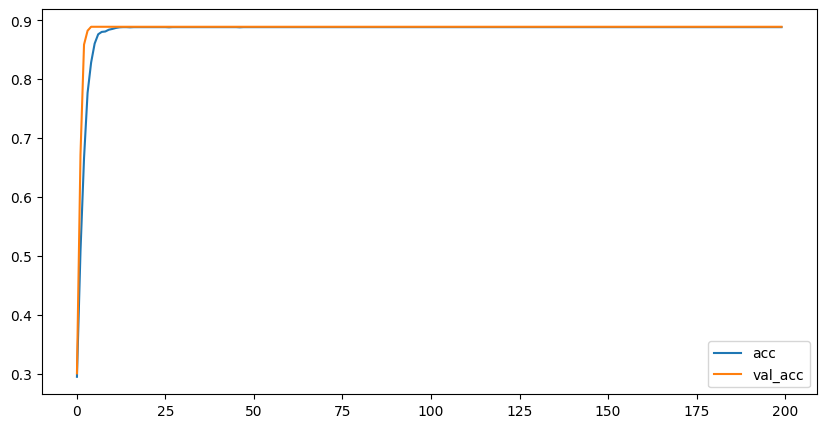

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc', 'val_acc'])

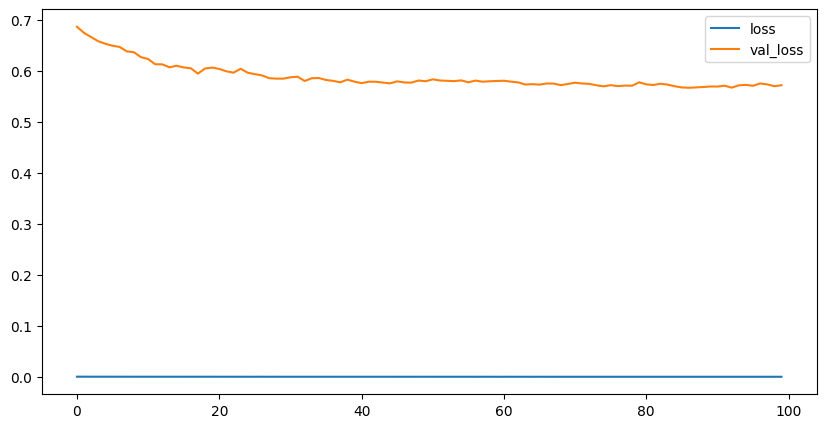

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])